# Tutorial 4 - Decision trees and random forests

In this tutorial, we'll take a look at decision trees, their splitting criteria and reandom forests.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree

Let's again use the Iris dataset as our example:

In [2]:
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Features: {iris.feature_names}")
print(f"Target Classes: {iris.target_names}")

Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Target Classes: ['setosa' 'versicolor' 'virginica']


## Decision trees

A Decision Tree is a flowchart-like structure where an internal node represents a feature (or attribute), the branch represents a decision rule, and each leaf node represents the outcome (class label or continuous value). The goal is to split the data into groups that are as distinct (homogeneous) as possible. To do this, the tree asks a series of True/False questions.

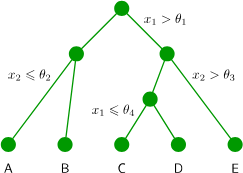

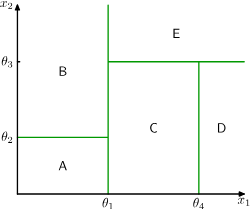

([source](https://link.springer.com/book/9780387310732))

In [3]:
model_sklearn = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=42)
model_sklearn.fit(X_train, y_train)

print(f"Train accuracy: {accuracy_score(y_train, model_sklearn.predict(X_train)):.2f}")
print(f"Test accuracy: {accuracy_score(y_test, model_sklearn.predict(X_test)):.2f}")

Train accuracy: 0.96
Test accuracy: 1.00


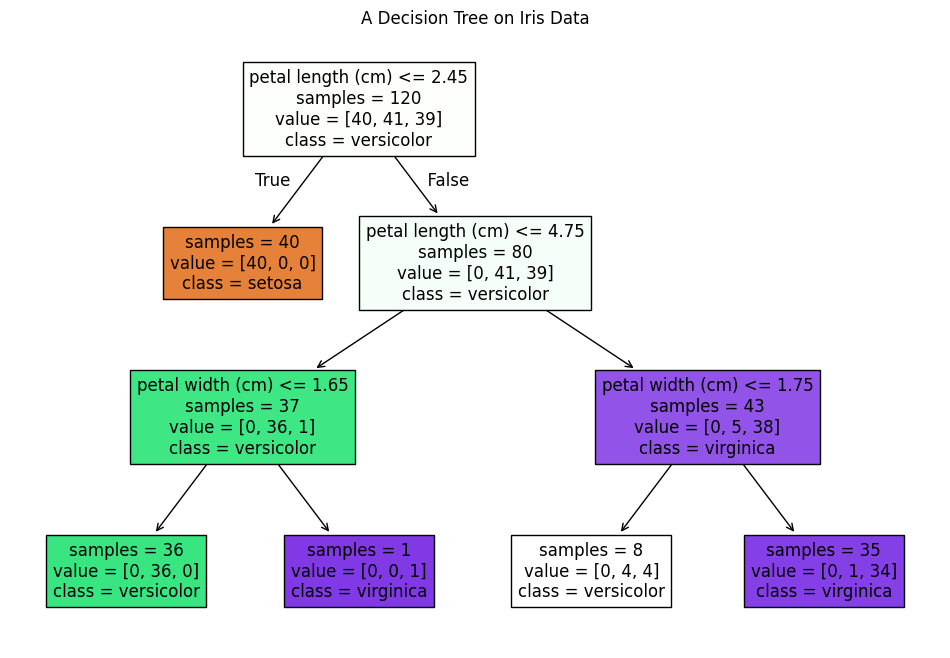

In [4]:
plt.figure(figsize=(12,8))
plot_tree(model_sklearn, feature_names=iris.feature_names, class_names=iris.target_names, filled=True, impurity=False)
plt.title("A Decision Tree on Iris Data")
plt.show()

### Training a decision tree

The training process of training a decision tree is essentially a process of dividing the set of all training samples.

1. We start with one leaf node containing all the samples.
2. We can convert a leaf node to a decision node and add 2 leaf nodes under it. We try to find the most consistent split.
3. We define some stoping citeria, such as the maximum depth of the tree or the minimum number of samples in a leaf node
4. We split all nodes as long as the stopping criteria aren't met (DFS, but that doesn't matter)

#### Splitting criteria

We need to define a way of finding the best split in each step. Given a node $\mathcal{T}$, the goal is to find:
- A feature and
- A value
Such that splitting $\mathcal{T}$ by this boundary into $\mathcal{T}_L$ and $\mathcal{T}_R$ leads to the best prediction.

Suppose we have an *impurity criterion* $c$ telling us how homogenous the samples of $\mathcal{T}$ are. Then we can choose such a split that minimizes $c(\mathcal{T}_L) + c(\mathcal{T}_R) - c(\mathcal{T})$.

Let $C$ be a set of classes, $I_\mathcal{T}$ the set of samples in the node $\mathcal{T}$ and $p_\mathcal{T}(k)$ the average empirical probability of class $k$ for samples in node $\mathcal{T}$. For classification, the typical criteria are the Gini index and the entropy criterion:

$$c_\mathrm{gini}(\mathcal{T}) = \lvert I_\mathcal{T} \rvert \sum_k^C p_\mathcal{T}(k) (1-p_\mathcal{T}(k))$$
$$c_\mathrm{entropy}(\mathcal{T}) = - \lvert I_\mathcal{T} \rvert \sum_k^C p_\mathcal{T}(k) \log p_\mathcal{T}(k)$$


## Task 1

Finish the implementation of a decision tree.

In [5]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, criterion_change=None, value=None):
        # Decision node
        self.feature_index = feature_index # Number corresponding to the decision feature
        self.threshold = threshold # Threshold feature value
        self.left = left # Left subtree
        self.right = right # Right subtree
        self.criterion_change = criterion_change # c(T_L) + c(T_R) - c(T)
        
        # Leaf node
        self.value = value

In [6]:
class MyDecisionTree:
    def __init__(self, min_samples_split=2, max_depth=3, criterion="gini"):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.criterion = criterion

    def build_tree(self, X, y, curr_depth=0):
        num_samples, num_features = np.shape(X)
        
        # Check stopping criteria
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            # Find the best split
            best_split = self.find_best_split(X, y, num_samples, num_features)
            
            # If criterion would improve, continue growing
            if best_split["criterion_change"] < 0:
                left_subtree = self.build_tree(best_split["X_left"], best_split["y_left"], curr_depth + 1)
                right_subtree = self.build_tree(best_split["X_right"], best_split["y_right"], curr_depth + 1)
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["criterion_change"])

        return Node(value=np.argmax(np.bincount(y)))
    
    def find_best_split(self, X, y, num_samples, num_features):
        best_split = {"criterion_change": float("inf")}
        
        # Loop over all features
        for feature_index in range(num_features):
            feature_values = X[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            
            # Loop over all unique feature values present in the data
            for threshold in possible_thresholds:
                X_left, y_left, X_right, y_right = self.split(X, y, feature_index, threshold)
                
                if len(X_left) > 0 and len(X_right) > 0:
                    criterion_change = self.criterion_change(y, y_left, y_right)
                    
                    if criterion_change < best_split["criterion_change"]:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["X_left"] = X_left
                        best_split["y_left"] = y_left
                        best_split["X_right"] = X_right
                        best_split["y_right"] = y_right
                        best_split["criterion_change"] = criterion_change
                        
        return best_split
    
    def split(self, X, y, feature_index, threshold):
        # Splitting logic: <= threshold goes left, > goes right
        X_left = np.array([row for row in X if row[feature_index] <= threshold])
        y_left = np.array([y[i] for i in range(y.shape[0]) if X[i][feature_index] <= threshold])
        X_right = np.array([row for row in X if row[feature_index] > threshold])
        y_right = np.array([y[i] for i in range(y.shape[0]) if X[i][feature_index] > threshold])
        return X_left, y_left, X_right, y_right
    
    def criterion_change(self, y_parent, y_left, y_right):
        return self.criterion(y_left) + self.criterion(y_right) - self.criterion(y_parent)

    def criterion(self, y):
        if self.criterion == "gini":
            return gini_index(y)
        else:
            raise NotImplementedError
    
    def gini_index(self, y):
        classes = np.unique(y)
        sum_value = 0
        for cls in classes:
            p_cls = len(y[y == cls]) / len(y)
            sum_value += p_cls**2
        return len(y) * (1 - sum_value)
    
    def fit(self, X, y):
        self.root = self.build_tree(X, y)
    
    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions
    
    def make_prediction(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature_index] <= node.threshold:
            return self.make_prediction(x, node.left)
        else:
            return self.make_prediction(x, node.right)

In [7]:
model_manual = MyDecisionTree()
model_manual.fit(X_train, y_train)

print(f"Train accuracy: {accuracy_score(y_train, model_manual.predict(X_train)):.2f}")
print(f"Test accuracy: {accuracy_score(y_test, model_manual.predict(X_test)):.2f}")

Train accuracy: 0.97
Test accuracy: 1.00


## Random forrests

A single Decision Tree is prone to overfitting - it can become too complex and memorize the noise in the training data. A Random Forest is an ensemble method that trains many decision trees on random subsets of the data and averages their predictions.

To mitigate this, we can generally use *ensembling* - combining several models to achieve superior performance.

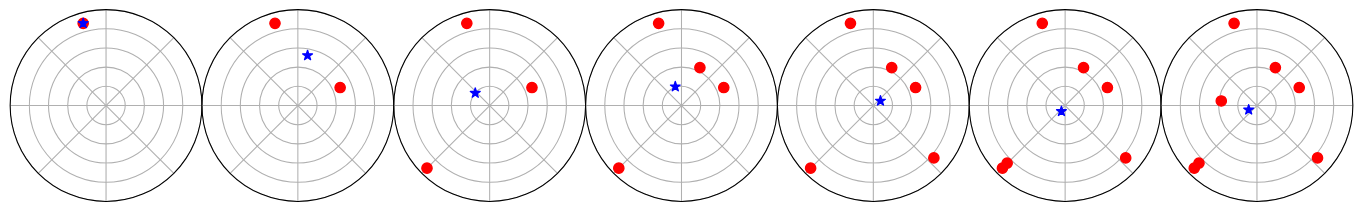

([source](https://ufal.mff.cuni.cz/~courses/npfl129/2526/slides/?09#5))

### Using ensembling for decision trees

We use ensembling to combine multiple decision trees, each of which is modified in 2 ways:
- **Bagging**: Training each tree on a random sample of the data with replacement.
- **Feature Randomness**: When splitting a node, the algorithm searches for the best feature among a random subset of features, not all features.

To predict, we use the majority voting scheme accross all the trees in the ensemble.

In [8]:
model_rf_sklearn = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)
model_rf_sklearn.fit(X_train, y_train)

print(f"Train Accuracy: {accuracy_score(y_train, model_rf_sklearn.predict(X_train)):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, model_rf_sklearn.predict(X_test)):.2f}")

Train Accuracy: 1.00
Test Accuracy: 1.00


## Task 2
Finish the implementation of a random forrest. Use the `DecisionTreeClassifier` from scikit-learn. Hint: to implement feature randomness, pass the `max_features` argument to `DecisionTreeClassifier`.

In [9]:
class MyRandomForest:
    def __init__(self, n_estimators=100, max_depth=3, max_features='sqrt'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]
        
        for i in range(self.n_estimators):
            idxs = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[idxs]
            y_sample = y[idxs]

            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                max_features=self.max_features,
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            
    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        y_pred = stats.mode(tree_preds, axis=0, keepdims=True)[0]
        
        return y_pred.flatten()

In [10]:
model_rf_manual = MyRandomForest()
model_rf_manual.fit(X_train, y_train)

print(f"Train Accuracy: {accuracy_score(y_train, model_rf_manual.predict(X_train)):.2f}")
print(f"Test Accuracy: {accuracy_score(y_test, model_rf_manual.predict(X_test)):.2f}")

Train Accuracy: 0.97
Test Accuracy: 1.00
